# Stacking

In [28]:
%reset -f

In [1]:
from scipy                         import stats
from statsmodels.tsa.stattools     import acf
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.preprocessing         import StandardScaler
from sklearn.metrics               import mean_squared_error, mean_absolute_error
from sklearn.model_selection       import GridSearchCV, TimeSeriesSplit, cross_val_score, cross_validate
from sklearn.neural_network        import MLPRegressor
from sklearn.ensemble              import RandomForestRegressor
from sklearn.linear_model          import LinearRegression, Lasso, RidgeCV

import csv
import xgboost           as xgb
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt
import pandas            as pd
import statsmodels.api   as sm

In [30]:
sns.set_style('darkgrid')
pd.plotting.register_matplotlib_converters()
sns.mpl.rc('figure',figsize=(16, 6))

In [2]:
f = pd.read_csv('pollution.csv')
df = pd.DataFrame(f)

In [3]:
df.columns

Index(['pm25', 'dewp', 'temp', 'cws', 'target', 'cbwd_1', 'cbwd_2', 'cbwd_3',
       'clunar', 'cstorm', 'cwkend', 'nord_cws', 'date', 'cmonth_2.0',
       'cmonth_3.0', 'cmonth_4.0', 'cmonth_5.0', 'cmonth_6.0', 'cmonth_7.0',
       'cmonth_8.0', 'cmonth_9.0', 'cmonth_10.0', 'cmonth_11.0', 'cmonth_12.0',
       'chour_1.0', 'chour_2.0', 'chour_3.0', 'chour_4.0', 'chour_5.0',
       'chour_6.0', 'chour_7.0', 'chour_8.0', 'chour_9.0', 'chour_10.0',
       'chour_11.0', 'chour_12.0', 'chour_13.0', 'chour_14.0', 'chour_15.0',
       'chour_16.0', 'chour_17.0', 'chour_18.0', 'chour_19.0', 'chour_20.0',
       'chour_21.0', 'chour_22.0', 'chour_23.0', 'pm25_1', 'pm25_2'],
      dtype='object')

In [33]:
df.describe()

,pm25,dewp,temp,cws,target,cbwd_1,cbwd_2,cbwd_3,clunar,cstorm,...,chour_16.0,chour_17.0,chour_18.0,chour_19.0,chour_20.0,chour_21.0,chour_22.0,chour_23.0,pm25_1,pm25_2
count,43795.000000,43795.000000,43795.000000,43795.000000,43795.000000,43795.000000,43795.000000,43795.000000,43795.000000,43795.000000,...,43795.000000,43795.000000,43795.000000,43795.000000,43795.000000,43795.000000,43795.000000,43795.000000,43795.000000,43795.000000
mean,98.022080,1.830323,12.460920,23.307569,98.019203,0.214271,0.322617,0.114077,0.000799,0.000046,...,0.041671,0.041671,0.041671,0.041671,0.041671,0.041671,0.041671,0.041671,98.026030,98.029433
std,90.523132,14.429070,12.192778,50.054601,90.523864,0.410320,0.467483,0.317908,0.028259,0.006758,...,0.199840,0.199840,0.199840,0.199840,0.199840,0.199840,0.199840,0.199840,90.522979,90.522470
min,0.000000,-40.000000,-19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,-10.000000,2.000000,1.000000,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,30.000000,30.000000
50%,74.000000,2.000000,14.000000,5.000000,74.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,74.000000,74.000000
75%,134.000000,15.000000,23.000000,21.000000,134.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,134.000000,134.000000
max,994.000000,28.000000,42.000000,585.000000,994.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,994.000000,994.000000


In [34]:
df.head(10)

,pm25,dewp,temp,cws,target,cbwd_1,cbwd_2,cbwd_3,clunar,cstorm,...,chour_16.0,chour_17.0,chour_18.0,chour_19.0,chour_20.0,chour_21.0,chour_22.0,chour_23.0,pm25_1,pm25_2
0,138,-7,-5,6,109,0,0,0,0,0,...,0,0,0,0,0,0,0,0,181,159
1,109,-7,-6,7,105,0,0,0,0,0,...,0,0,0,0,0,0,0,0,138,181
2,105,-7,-6,8,124,0,0,0,0,0,...,0,0,0,0,0,0,0,0,109,138
3,124,-7,-5,10,120,0,0,0,0,0,...,0,0,0,0,0,0,0,0,105,109
4,120,-8,-6,12,132,0,0,0,0,0,...,0,0,0,0,0,0,0,0,124,105
5,132,-7,-5,14,140,0,0,0,0,0,...,0,0,0,0,0,0,0,0,120,124
6,140,-7,-5,17,152,0,0,0,0,0,...,0,0,0,0,0,0,0,0,132,120
7,152,-8,-5,20,148,0,0,0,0,0,...,0,0,0,0,0,0,0,0,140,132
8,148,-8,-5,23,164,0,0,0,0,0,...,0,0,0,0,0,0,0,0,152,140
9,164,-8,-5,27,158,0,0,0,0,0,...,0,0,0,0,0,0,0,0,148,152


In [4]:
df['date'] = pd.to_datetime(df.date)

In [5]:
# Setting DateTime index
df['date'] = pd.to_datetime(df.date)
df.set_index('date', inplace=True)

In [6]:
df[['pm25', 'target']].describe()

,pm25,target
count,43795.000000,43795.000000
mean,98.022080,98.019203
std,90.523132,90.523864
min,0.000000,0.000000
25%,30.000000,30.000000
50%,74.000000,74.000000
75%,134.000000,134.000000
max,994.000000,994.000000


In [7]:
# Check for any NaN or infinite values across rows
df[df.isin([np.nan, np.inf, -np.inf]).any(axis=1)].count().sum()

0

# Subset data into 3 consectuive sections (Time Series CV)

### To run a two-step stacked time-series model, the temporal order of the data needs to be strictly followed. Hence, we can only split the data into three ordered batches.

### The first (earliest) batch we will call the base-training set and is a gridsearch hyper-parameter tuning of the base models.

### The optimised base model then makes an out-of-sample prediction on the next batch of data, which is used to train the meta model (Calling this data the meta-training set)

### The Meta fitted model then makes an out-of-sample prediction on the final batch of data, which is used for scoring the models performance (calling this data the test set)

In [8]:
# Extract the last 10% of observations as the test set
df_test = df.iloc[-4380:]
df_rest = df.iloc[:-4380]

In [9]:
y_test = df_test.pop('target')

In [10]:
y = df_rest.pop('target')

In [11]:
X = df_rest

### The remaining data before the test set is split 2/3 base-training and 1/3 meta-training sets

In [13]:
c = len(y)/3

In [14]:
# Data is organized in declining chronological order
y_meta = y[-int(c):]
y_base = y[:-int(c)]

In [15]:
X_meta = X[-int(c):]
X_base = X[:-int(c)]

In [46]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4380 entries, 2014-02-07 11:00:00 to 2014-12-31 22:00:00
Data columns (total 47 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   pm25         4380 non-null   int64
 1   dewp         4380 non-null   int64
 2   temp         4380 non-null   int64
 3   cws          4380 non-null   int64
 4   cbwd_1       4380 non-null   int64
 5   cbwd_2       4380 non-null   int64
 6   cbwd_3       4380 non-null   int64
 7   clunar       4380 non-null   int64
 8   cstorm       4380 non-null   int64
 9   cwkend       4380 non-null   int64
 10  nord_cws     4380 non-null   int64
 11  cmonth_2.0   4380 non-null   int64
 12  cmonth_3.0   4380 non-null   int64
 13  cmonth_4.0   4380 non-null   int64
 14  cmonth_5.0   4380 non-null   int64
 15  cmonth_6.0   4380 non-null   int64
 16  cmonth_7.0   4380 non-null   int64
 17  cmonth_8.0   4380 non-null   int64
 18  cmonth_9.0   4380 non-null   int64
 19  cmonth_10.0 

In [47]:
X_meta.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13138 entries, 2013-01-01 01:00:00 to 2014-02-07 10:00:00
Data columns (total 47 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   pm25         13138 non-null  int64
 1   dewp         13138 non-null  int64
 2   temp         13138 non-null  int64
 3   cws          13138 non-null  int64
 4   cbwd_1       13138 non-null  int64
 5   cbwd_2       13138 non-null  int64
 6   cbwd_3       13138 non-null  int64
 7   clunar       13138 non-null  int64
 8   cstorm       13138 non-null  int64
 9   cwkend       13138 non-null  int64
 10  nord_cws     13138 non-null  int64
 11  cmonth_2.0   13138 non-null  int64
 12  cmonth_3.0   13138 non-null  int64
 13  cmonth_4.0   13138 non-null  int64
 14  cmonth_5.0   13138 non-null  int64
 15  cmonth_6.0   13138 non-null  int64
 16  cmonth_7.0   13138 non-null  int64
 17  cmonth_8.0   13138 non-null  int64
 18  cmonth_9.0   13138 non-null  int64
 19  cmonth_10.0

In [48]:
X_base.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26277 entries, 2010-02-01 04:00:00 to 2013-01-01 00:00:00
Data columns (total 47 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   pm25         26277 non-null  int64
 1   dewp         26277 non-null  int64
 2   temp         26277 non-null  int64
 3   cws          26277 non-null  int64
 4   cbwd_1       26277 non-null  int64
 5   cbwd_2       26277 non-null  int64
 6   cbwd_3       26277 non-null  int64
 7   clunar       26277 non-null  int64
 8   cstorm       26277 non-null  int64
 9   cwkend       26277 non-null  int64
 10  nord_cws     26277 non-null  int64
 11  cmonth_2.0   26277 non-null  int64
 12  cmonth_3.0   26277 non-null  int64
 13  cmonth_4.0   26277 non-null  int64
 14  cmonth_5.0   26277 non-null  int64
 15  cmonth_6.0   26277 non-null  int64
 16  cmonth_7.0   26277 non-null  int64
 17  cmonth_8.0   26277 non-null  int64
 18  cmonth_9.0   26277 non-null  int64
 19  cmonth_10.0

# Baseline Model Scores

### Gridsearch First Stage Base Models

#### Scale each variable to mean 0 and standard deviation 1

In [49]:
scaler = StandardScaler()

In [50]:
# Fit-transform the first batch base-training set, and only transform the latter two batches
X_base = scaler.fit_transform(X_base)
X_meta = scaler.transform(X_meta)
X_test = scaler.transform(df_test)

In [51]:
#Make an inner validation scheme for Gridsearch Cross-Validation
time_split_inner = TimeSeriesSplit(n_splits = 3) # These splits are used to find the best GS hyper-parameters

### GridsearchCV : Lasso Regression

In [52]:
lasso = Lasso(fit_intercept=1, alpha=0.05, max_iter=10000, random_state=0)

las_params = {'fit_intercept': [1, 0],
              'alpha': [0.005, 0.01, 0.03, 0.05, 0.07, 0.1]}

In [53]:
gs_las = GridSearchCV(lasso, las_params, cv=time_split_inner, scoring='neg_mean_squared_error', 
                      n_jobs=-1, verbose=1)

gs_las.fit(X_base, y_base)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=Lasso(alpha=0.05, fit_intercept=1, max_iter=10000,
                             random_state=0),
             n_jobs=-1,
             param_grid={'alpha': [0.005, 0.01, 0.03, 0.05, 0.07, 0.1],
                         'fit_intercept': [1, 0]},
             scoring='neg_mean_squared_error', verbose=1)

### GridsearchCV : two-Layer neural network

In [54]:
mlp = MLPRegressor(hidden_layer_sizes=(24,), alpha=1e-6, activation='relu', early_stopping=True, max_iter=20000, random_state=0)

mlp_params = {'hidden_layer_sizes': [(24,), (36,), (24,24), (24,12), (36,24), (36,12)], 
              'alpha': [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3],
              'activation': ['relu', 'identity', 'tanh']}

In [55]:
gs_mlp = GridSearchCV(mlp, mlp_params, cv=time_split_inner, scoring='neg_mean_squared_error', 
                      n_jobs=-1, verbose=1)

gs_mlp.fit(X_base, y_base)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=MLPRegressor(alpha=1e-06, early_stopping=True,
                                    hidden_layer_sizes=(24,), max_iter=20000,
                                    random_state=0),
             n_jobs=-1,
             param_grid={'activation': ['relu', 'identity', 'tanh'],
                         'alpha': [1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001],
                         'hidden_layer_sizes': [(24,), (36,), (24, 24),
                                                (24, 12), (36, 24), (36, 12)]},
             scoring='neg_mean_squared_error', verbose=1)

### GridsearchCV : Random Forest

In [56]:
rf = RandomForestRegressor(n_estimators=400, min_samples_split=3, max_features='sqrt', random_state=0)

rf_params = {'n_estimators': range(300, 500, 25),
             'min_samples_split': [2, 3, 4, 5, 6, 7],
             'max_features': ['log2', 'sqrt']}

In [57]:
gs_rf = GridSearchCV(rf, rf_params, cv=time_split_inner, scoring = 'neg_mean_squared_error', 
                     n_jobs=-1, verbose=1)

gs_rf.fit(X_base, y_base)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=RandomForestRegressor(max_features='sqrt',
                                             min_samples_split=3,
                                             n_estimators=400, random_state=0),
             n_jobs=-1,
             param_grid={'max_features': ['log2', 'sqrt'],
                         'min_samples_split': [2, 3, 4, 5, 6, 7],
                         'n_estimators': range(300, 500, 25)},
             scoring='neg_mean_squared_error', verbose=1)

### GridsearchCV : XGBoost

In [58]:
xgb = xgb.XGBRegressor(n_estimators=100, gamma=200, eta=0.1, subsample=1, objective='reg:squarederror', random_state=0)

xgb_params = {'n_estimators': range(70, 140, 10),
              'subsample': [0.5, 0.75, 1],
              'eta': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4],
              'gamma': range(150, 160, 10)}

# gamma range changed from 150-310 to 150-160

In [59]:
# Fitting/Training the base models to the base-training set
gs_xgb = GridSearchCV(xgb, xgb_params, cv=time_split_inner, scoring = 'neg_mean_squared_error', n_jobs=-1, verbose=1)

gs_xgb.fit(X_base, y_base)

Fitting 3 folds for each of 126 candidates, totalling 378 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eta=0.1,
                                    eval_metric=None, gamma=200, gpu_id=None,
                                    grow_policy=None, importance_type...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=0,
 

### check the optimal parameters for each model

In [60]:
gs_las.best_params_

{'alpha': 0.05, 'fit_intercept': 1}

In [61]:
gs_mlp.best_params_

{'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (36, 24)}

In [62]:
gs_rf.best_params_

{'max_features': 'sqrt', 'min_samples_split': 3, 'n_estimators': 300}

In [63]:
gs_xgb.best_params_

{'eta': 0.1, 'gamma': 150, 'n_estimators': 80, 'subsample': 0.75}

# Setting & Training the Meta Model

### The out-of-sample predictions of the optimized base models will form the features for the meta model, and the actual PM 2.5 readings will form the target of the meta model.

### The meta model can be a simple linear regression with constant term. You can used more complicated model like Ridge regression

In [64]:
est_meta = pd.DataFrame(y_meta)

### The predictions of the base models on the meta-training set, which will be used to train the meta model

In [65]:
est_meta['las_pred'] = gs_las.predict(X_meta)
est_meta['mlp_pred'] = gs_mlp.predict(X_meta)
est_meta['rf_pred'] = gs_rf.predict(X_meta)
est_meta['xgb_pred'] = gs_xgb.predict(X_meta)

In [66]:
y_meta = est_meta.pop('target')

### Setting Linear Regression as the final stage meta model

In [67]:
meta = LinearRegression()

### Fitting the meta model to the predictions of the base models on the meta-training set, and y_meta

In [68]:
meta.fit(est_meta, y_meta)

LinearRegression()

# Predicting the test Data

### The base (first stage) and meta models are not retrained before making predictions on the test set.

In [69]:
y_test

date
2014-02-07 11:00:00    56
2014-02-07 12:00:00    64
2014-02-07 13:00:00    66
2014-02-07 14:00:00    72
2014-02-07 15:00:00    78
                       ..
2014-12-31 18:00:00     8
2014-12-31 19:00:00    10
2014-12-31 20:00:00    10
2014-12-31 21:00:00     8
2014-12-31 22:00:00    12
Name: target, Length: 4380, dtype: int64

# Analytical Functions for Evaluations

In [70]:
def reg_scoring(X, y, meta, reg_dict):
    '''
    Objective: Cycles through a dictionary of trained models, using them to make predictions, scores those 
    predictions on MAE, MSE & RMSE, and generates DataFrames of the scores and model predictions respectively
    
    X: DataFrame containing the explanatory variables
    
    y: Target variable
    
    meta: Trained meta model
    
    reg_dict: Dictionary of trained/fitted models
    '''
    
    test1_scores = []
    test2_scores = []
    
    df_pred = pd.DataFrame(columns=reg_dict.keys()) # Columns of DF will accord with reg_dict keys
    
    # Loop through Dictionary items
    for key, reg in reg_dict.items():
        
        pred_y = reg.predict(X)
        df_pred[key] = pd.Series(pred_y).transpose()
        
        # Computing test scores for each model
        test1_scores.append(round(mean_absolute_error(y, pred_y), 4))
        test2_scores.append(round(mean_squared_error(y, pred_y, squared=False), 4))
        
    # Generate results DataFrame
    results = pd.DataFrame({'Model': list(reg_dict.keys()), 
                            'Mean Absolute Error': test1_scores,
                            'Root Mean Squared Error': test2_scores
                            })

    # Generate Stack Model's predictions, and test scores
    df_pred['Stack Model'] = meta.predict(df_pred) # Adding 'Stack Model' to DataFrame of predictions
    
    s1 = round(mean_absolute_error(y, df_pred['Stack Model']), 4)
    s2 = round(mean_squared_error(y, df_pred['Stack Model'], squared=False), 4)
    
    
    # Add target variable to the DataFrame of predictions
    df_pred['Target'] = y.tolist()
        
        
    # Inserting the Stack scores to the results DataFrame
    row1 = ['Stack Model', s1, s2]
    results.loc[len(results)] = row1
    
    return results, df_pred

In [71]:
def residual_plot(res):
    '''
    Objective: Generates four charts to assess the residuals of the model predictions -  
    a residual line chart through time; an ACF plot of residuals; a residual Q-Q plot; 
    and a kde histogram of residuals
    
    res: Residuals between the true target variable values and the model predictions
    '''
    # Standardizing residual values
    resid_standard = (res - res.mean()) / res.std()
    
    # Generate 2X2 chart plots
    figure, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))

    ax[0, 0].plot(res)
    ax[0, 0].axhline(res.mean(), color='grey')
    ax[0, 0].set_title('Residuals')

    plot_acf(resid_standard, title='Correlogram', ax=ax[0, 1])

    sm.graphics.qqplot(res, line='45', fit=True, ax=ax[1, 0])
    ax[1, 0].set_title('Normal Q-Q')

    x = np.linspace(res.min(), res.max(), 1000)
    norm = stats.norm(loc=0, scale=res.std())
    sns.distplot(res, ax=ax[1, 1], label='kde estimate')
    ax[1, 1].plot(x, norm.pdf(x), label='normal distribution')
    ax[1, 1].legend()
    ax[1, 1].set_title('Distribution of Residuals')

    plt.show()

In [72]:
# Dictionary of TRAINED base models
reg_dict = {
    'Lasso Regression': gs_las,
    'Multi-Layer Perceptron': gs_mlp, 
    'Random Forest': gs_rf,
    'XG Boost': gs_xgb
}

# Comparative Test Scores & Plots

In [73]:
scores, df_pred = reg_scoring(X_test, y_test, meta, reg_dict)

In [74]:
scores

,Model,Mean Absolute Error,Root Mean Squared Error
0,Lasso Regression,10.9419,18.8499
1,Multi-Layer Perceptron,11.1703,18.9255
2,Random Forest,12.3241,20.4139
3,XG Boost,10.7249,18.9503
4,Stack Model,10.5593,18.6608


### The Stack Model has the lowest (and best) MAE and RMSE scores of all the models

In [75]:
df_pred.index = df_test.index

### now let's plot forecast on the test data

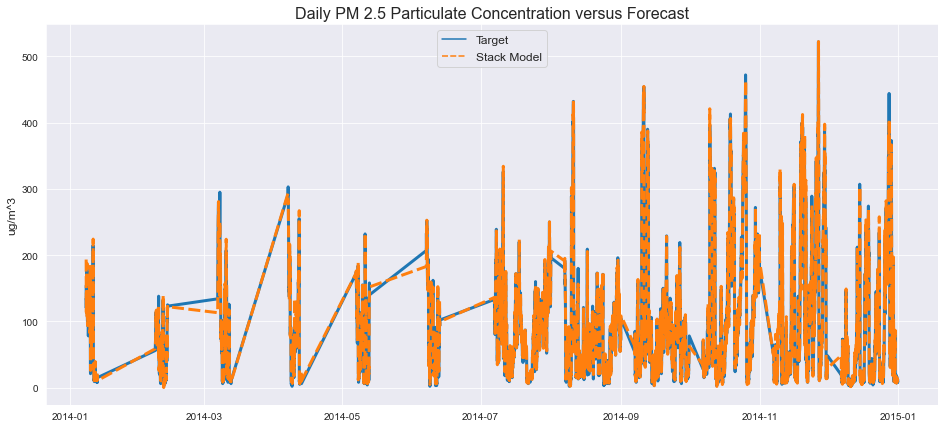

In [76]:
fig, ax = plt.subplots(figsize=(16,7))

sns.lineplot(data=df_pred[['Target', 'Stack Model']], ax=ax, linewidth=3)
plt.legend(loc='upper center', fontsize=12)
plt.title('Daily PM 2.5 Particulate Concentration versus Forecast', fontsize=16)
plt.xlabel('')
plt.ylabel('ug/m^3', fontsize=12);

### Model predictions on first 400 observations of test data

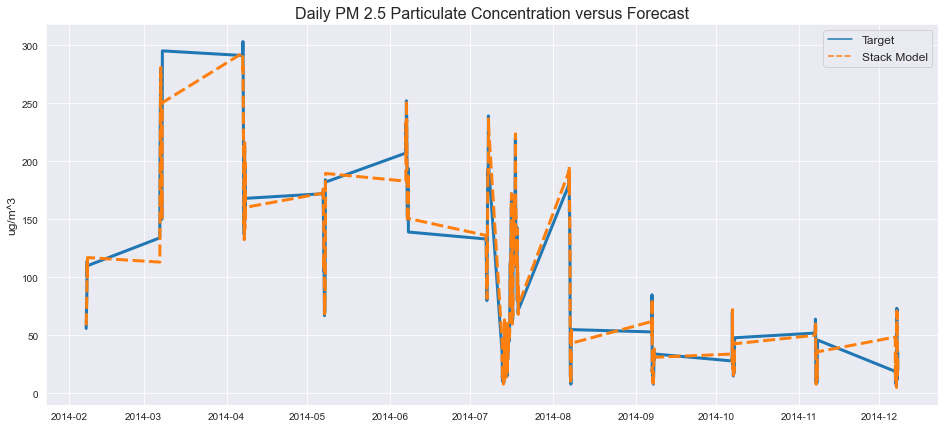

In [77]:
fig, ax = plt.subplots(figsize=(16,7))

sns.lineplot(data=df_pred[['Target', 'Stack Model']].iloc[:400], ax=ax, linewidth=3)
plt.legend(loc='upper right', fontsize=12)
plt.title('Daily PM 2.5 Particulate Concentration versus Forecast', fontsize=16)
plt.xlabel('')
plt.ylabel('ug/m^3', fontsize=12);

### Model predictions on middle 400 observations of test data

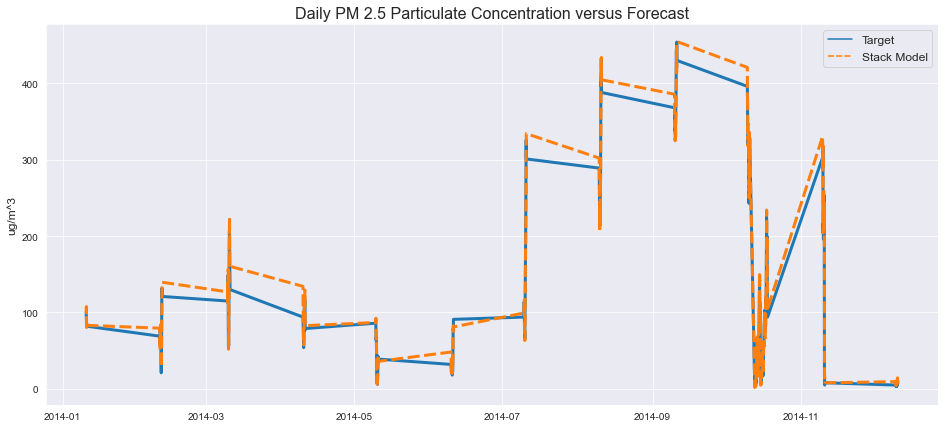

In [78]:
fig, ax = plt.subplots(figsize=(16,7))

sns.lineplot(data=df_pred[['Target', 'Stack Model']].iloc[2190:2590], ax=ax, linewidth=3)
plt.legend(loc='upper right', fontsize=12)
plt.title('Daily PM 2.5 Particulate Concentration versus Forecast', fontsize=16)
plt.xlabel('')
plt.ylabel('ug/m^3', fontsize=12);

In [79]:
### Model predictions on last 400 observations of test data

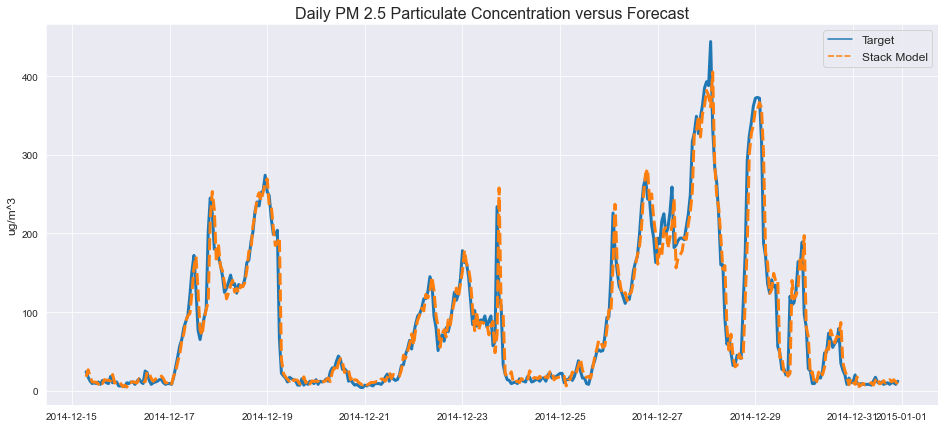

In [80]:
fig, ax = plt.subplots(figsize=(16,7))

sns.lineplot(data=df_pred[['Target', 'Stack Model']].iloc[-400:], ax=ax, linewidth=3)
plt.legend(loc='upper right', fontsize=12)
plt.title('Daily PM 2.5 Particulate Concentration versus Forecast', fontsize=16)
plt.xlabel('')
plt.ylabel('ug/m^3', fontsize=12);

# Residual Plots

In [81]:
residual = df_pred['Target'] - df_pred['Stack Model']

C:\Users\Micha\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


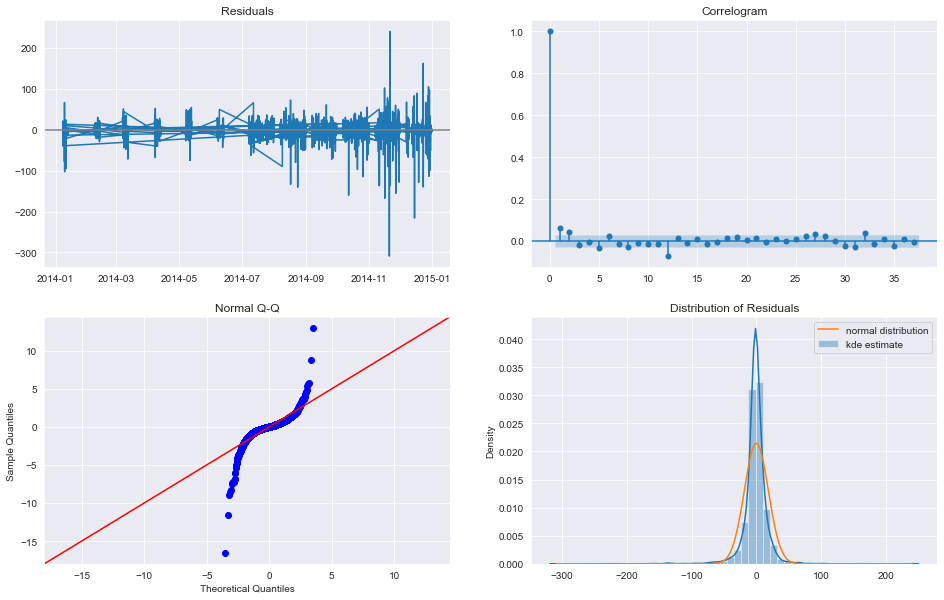

In [82]:
residual_plot(residual)

In [83]:
df_resid = df_pred.iloc[:,:-1].sub(df_pred['Target'], axis=0)

In [84]:
df_resid.describe()

,Lasso Regression,Multi-Layer Perceptron,Random Forest,XG Boost,Stack Model
count,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000
mean,0.707347,1.190620,1.956956,1.167045,1.370977
std,18.838746,18.890190,20.322225,18.916440,18.612494
min,-237.298201,-243.213592,-232.617352,-239.347164,-240.336444
25%,-6.146734,-6.166098,-5.376542,-5.434578,-5.490025
50%,0.846749,1.534383,2.577504,1.384038,0.859734
75%,7.127268,7.657990,8.708373,6.803341,6.910670
max,299.031406,302.925136,303.450270,311.196533,308.712590


### Box-plots for the residuals across the base and meta models

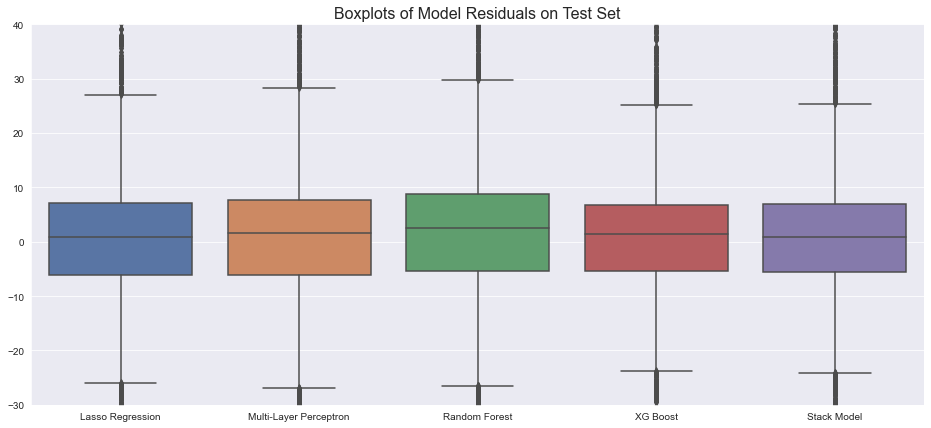

In [85]:
plt.figure(figsize=(16,7))

ax=sns.boxplot(data=df_resid, orient='v', palette = sns.color_palette("deep", 5))
ax.set(ylim=(-30, 40))

plt.title('Boxplots of Model Residuals on Test Set', fontsize=16)
plt.xlabel('')
plt.ylabel('');